# 모듈 로드

In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook as tqdm
import xgboost as xgb
import lightgbm as lgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")
gc.enable()

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

# 데이터 로드

## 일반 데이터

In [179]:
train_raw = pd.read_csv('./data/train.csv')
test_raw = pd.read_csv('./data/test.csv')
train_raw.shape, test_raw.shape

((200000, 202), (200000, 201))

In [180]:
train = train_raw.copy()
test = test_raw.copy()

In [181]:
train_0 = train[train.target == 0].copy()
train_1 = train[train.target == 1].copy()

In [182]:
col_list = train.columns[2:]

In [183]:
pb_idx = np.load('./data_temp/public_LB.npy')
pv_idx = np.load('./data_temp/private_LB.npy')

In [184]:
test_pb = test.iloc[pb_idx].sort_index().copy()
test_pv = test.iloc[pv_idx].sort_index().copy()

In [185]:
test_real = test_pb.append(test_pv)
# test_real['target'] = np.nan

In [186]:
data = train.append(test_real)

# 다양한 FE

In [339]:
train = train_raw.copy()
test = test_raw.copy()

In [340]:
# unique values
for col in tqdm(col_list):
    train[col + '_is_unique'] = (train[col].map(train[col].value_counts().to_dict()) == 1) * 1

In [325]:
# groupby order - var 68
group_var = 'var_68'
col = 'var_0'

for col in tqdm(col_list):
    train[col + '_groupby_var_68'] = train[group_var].map(np.around(train.groupby(group_var)[col].agg(['mean']), 4).to_dict()['mean'])

In [314]:
# order - unique
# for col in tqdm(col_list):
#     temp = train[col].value_counts().sort_index().to_frame()
#     order = [0]
    
#     for v in temp.iterrows():
#         order.append(order[-1] + v[1].values[0])
    
#     temp[col] = order[:-1]
#     temp = temp.to_dict()[col]

#     train[col + '_order'] = train[col].map(temp)

In [136]:
# order - dup
# for col in tqdm(col_list):
#     temp = train[col].value_counts().sort_index().to_frame()
#     temp[col] = list(range(temp.shape[0]))
#     temp = temp.to_dict()[col]
#     train[col + '_order'] = train[col].map(temp)

In [138]:
# value counts
# for col in tqdm(col_list):
#     train[col + '_value_counts'] = train[col].map(train[col].value_counts().to_dict())

In [139]:
# floating value
# for col in tqdm(col_list):
#     train[col + '_floating'] = (np.around(train[col], 4) != train[col]) * 1

In [140]:
# prediction
# train['pred'] = bbiggu.pred

In [342]:
train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7   var_8   var_9  var_10   var_11   var_12   var_13  var_14  \
0  18.6266 -4.9200  5.7470  2.9252   3.1821  14.0137   0.5745  8.7989   
1  16.5338  3.1468  8.0851 -0.4032   8.0585  14.0239   8.4135  5.4345   
2  14.6155 -4.9193  5.9525 -0.3249 -11.2648  14.1929   7.3124  7.5244   
3  14.9250 -5.8609  8.2450  2.3061   2.8102  13.8463  11.9704  6.4569   
4  19.2514  6.2654  7.6784 -9.4458 -12.1419  13.8481   7.8895  7.7894   

    var_15   var_16   var_17   var_18   var_19   var_20   var_21   var_22  \
0  14.5691   5.7487  -7.2393   4.2840  30.7133  10.5350  16.2191   2.5791   
1  13.7003  13.8275 -15.5849   7.8000  28.5708   3.4287   2.7407   8.5524   
2  14.6472   7.6782  -1.7395   4.7011  20.4775  17.7559  18.1377   1.2145   
3  14.8372  10.7430  -0.4299  15.9426  13.7257  20.3010  12.5579   6.8202   
4  15.0553   8.4871  -3.0680   6.5263  11.3152  21.4246  18.9608  10.1102   

   var_23   var_24   var_25   var_26  var_27  var_28  var_29   var_30  \
0  2.4716  14.3831  13.4325  -5.1488 -0.4073  4.9306  5.9965  -0.3085   
1  3.3716   6.9779  13.8910 -11.7684 -2.5586  5.0464  0.5481  -9.2987   
2  3.5137   5.6777  13.2177  -7.9940 -2.9029  5.8463  6.1439 -11.1025   
3  2.7229  12.1354  13.7367   0.8135 -0.9059  5.9070  2.8407 -15.2398   
4  2.7142  14.2080  13.5433   3.1736 -3.3423  5.9015  7.9352  -3.1582   

    var_31  var_32   var_33   var_34   var_35  var_36  var_37   var_38  \
0  12.9041 -3.8766  16.8911  11.1920  10.5785  0.6764  7.8871   4.6667   
1   7.8755  1.2859  19.3710  11.3702   0.7399  2.7995  5.8434  10.8160   
2  12.4858 -2.2871  19.0422  11.0449   4.1087  4.6974  6.9346  10.8917   
3  10.4407 -2.5731   6.1796  10.6093  -5.9158  8.1723  2.8521   9.1738   
4   9.4668 -0.0083  19.3239  12.4057   0.6329  2.7922  5.8184  19.3038   

   var_39   var_40   var_41   var_42   var_43   var_44   var_45   var_46  \
0  3.8743  -5.2387   7.3746  11.5767  12.0446  11.6418  -7.0170   5.9226   
1  3.6783 -11.1147   1.8730   9.8775  11.7842   1.2444 -47.3797   7.3718   
2  0.9003 -13.5174   2.2439  11.5283  12.0406   4.1006  -7.9078  11.1405   
3  0.6665  -3.8294  -1.0370  11.7770  11.2834   8.0485 -24.6840  12.7404   
4  1.4450  -5.5963  14.0685  11.9171  11.5111   6.9087 -65.4863  13.8657   

    var_47   var_48   var_49   var_50   var_51  var_52  var_53  var_54  \
0 -14.2136  16.0283   5.3253  12.9194  29.0460 -0.6940  5.1736 -0.7474   
1   0.1948  34.4014  25.7037  11.8343  13.2256 -4.1083  6.6885 -8.0946   
2  -5.7864  20.7477   6.8874  12.9143  19.5856  0.7268  6.4059  9.3124   
3 -35.1659   0.7613   8.3838  12.6832   9.5503  1.7895  5.2091  8.0913   
4   0.0444  -0.1346  14.4268  13.3273  10.4857 -1.4367  5.7555 -8.5414   

    var_55   var_56  var_57  var_58   var_59   var_60   var_61  var_62  \
0  14.8322  11.2668  5.3822  2.0183  10.1166  16.1828   4.9590  2.0771   
1  18.5995  19.3219  7.0118  1.9210   8.8682   8.0109  -7.2417  1.7944   
2   6.2846  15.6372  5.8200  1.1000   9.1854  12.5963 -10.3734  0.8748   
3  12.3972  14.4698  6.5850  3.3164   9.4638  15.7820 -25.0222  3.4418   
4  14.1482  16.9840  6.1812  1.9548   9.2048   8.6591 -27.7439 -0.4952   

   var_63  var_64  var_65  var_66   var_67  var_68  var_69   var_70  var_71  \
0 -0.2154  8.6748  9.5319  5.8056  22.4321  5.0109 -4.7010  21.6374  0.5663   
1 -1.3147  8.1042  1.5365  5.4007   7.9344  5.0220  2.2302  40.5632  0.5134   
2  5.8042  3.7163 -1.1016  7.3667   9.8565  5.0228 -5.7828   2.3612  0.8520   
3 -4.3923  8.6464  6.3072  5.6221  23.6143  5.0220 -3.9989   4.0462

## submission

In [199]:
##### order - unique
# for col in tqdm(col_list):
#     temp = data[col].value_counts().sort_index().to_frame()
#     order = [0]
    
#     for v in temp.iterrows():
#         order.append(order[-1] + v[1].values[0])
    
#     temp[col] = order[:-1]
#     temp = temp.to_dict()[col]

#     data[col + '_order'] = data[col].map(temp)

In [201]:
# is unique
for col in tqdm(col_list):
    data[col + '_is_unique'] = (data[col].map(data[col].value_counts().to_dict()) == 1) * 1

## 삐꾸 vs 정상

In [532]:
bbiggu = pd.read_csv('./data_temp/bbiggu_1.csv')
bbiggu['target'] = train.target

In [344]:
normal_idx = bbiggu[(bbiggu.target == 0) & (bbiggu.pred < 0.1)].index.values
bbiggu_idx = bbiggu[(bbiggu.target == 1) & (bbiggu.pred < 0.1)].index.values

In [345]:
temp_1 = train.iloc[normal_idx]
temp_2 = train.iloc[bbiggu_idx]
temp_1.target = 0
temp_2.target = 1

new_train = temp_1.append(temp_2).sort_index()

### 모델

In [346]:
target = new_train['target']

In [347]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 8
}

In [348]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(new_train))
feature_importance = pd.DataFrame()

train_columns = [c for c in new_train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(new_train, target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(new_train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(new_train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=400, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(new_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
        
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[400]	training's auc: 0.901636	valid_1's auc: 0.613928
[800]	training's auc: 0.937422	valid_1's auc: 0.636351
[1200]	training's auc: 0.956598	valid_1's auc: 0.652099
[1600]	training's auc: 0.967042	valid_1's auc: 0.662626
[2000]	training's auc: 0.97322	valid_1's auc: 0.667654
[2400]	training's auc: 0.977038	valid_1's auc: 0.673187
[2800]	training's auc: 0.981769	valid_1's auc: 0.674226
[3200]	training's auc: 0.984763	valid_1's auc: 0.677573
[3600]	training's auc: 0.987355	valid_1's auc: 0.682694
[4000]	training's auc: 0.989466	valid_1's auc: 0.684909
[4400]	training's auc: 0.991285	valid_1's auc: 0.685598
Early stopping, best iteration is:
[4266]	training's auc: 0.990787	valid_1's auc: 0.68631
CV score: 0.68631 
fold n°1
Training until validation scores don't improve for 200 rounds.
[400]	training's auc: 0.894738	valid_1's auc: 0.627494
[800]	training's auc: 0.933885	valid_1's auc: 0.650337
[1200]	training's auc: 0


[3262]	training's auc: 0.98448	valid_1's auc: 0.69868

[2727]	training's auc: 0.978068	valid_1's auc: 0.699068

[2176]	training's auc: 0.971125	valid_1's auc: 0.69391

[1368]	training's auc: 0.953092	valid_1's auc: 0.655778

[591]	training's auc: 0.916854	valid_1's auc: 0.661798

CV score: 0.67615 

* base CV score: 0.67258 
* Original CV score: 0.7561


In [434]:
temp = train_raw[col_list] * train.iloc[:, 402:].values

In [441]:
temp[train.target == 1].sum(axis=1)

13        122.3968
29        178.1577
63        177.0465
65        251.7427
71        404.0257
72        220.1630
84        252.1882
99        272.2211
119       131.1634
120       147.8289
130       218.3362
142       383.8467
178       199.3562
207       151.2831
223       303.5177
234       121.5073
235       232.6581
236       264.8449
239       258.8046
242       167.4214
252       213.0422
260       171.0692
284       204.3462
301       240.6999
309       128.0587
319        99.1897
324       242.1060
330       316.6107
332       203.1711
333       159.0438
335       263.9365
348       125.9684
355       245.5440
391       279.6612
394       236.9070
406       343.0263
410       184.8055
411       284.5293
420       160.4168
424       380.3818
454        88.5893
459       236.6046
475       401.7963
483       215.3954
487       195.5630
496       182.1792
507       111.6347
511       334.5075
514       159.8839
525       381.6024
532        50.9589
544       253.2795
549       18

In [553]:
temp.iloc[bbiggu_idx].head(20)

var_0   var_1    var_2  var_3    var_4    var_5  var_6    var_7  \
142  19.1223 -0.0000   0.0000    0.0   0.0000  -7.1490    0.0   0.0000   
207   0.0000  0.0000   0.0000    0.0   0.0000 -17.2914    0.0   0.0000   
301   0.0000 -0.0000   0.0000    0.0   0.0000   0.0000    0.0  14.7868   
348   0.0000  0.0000   0.0000    0.0   0.0000  -0.0000    0.0   0.0000   
391   0.0000  0.0000   0.0000    0.0   0.0000  -0.0000    0.0  22.2377   
410   0.0000  0.0000   0.0000    0.0   0.0000   3.7495    0.0  23.0580   
454   0.0000  0.0000   0.0000    0.0   0.0000   0.0000    0.0   0.0000   
487   0.0000 -5.4204   6.8469    0.0   0.0000  -0.0000    0.0   0.0000   
507   0.0000 -0.0000   0.0000    0.0   0.0000   0.0000    0.0   0.0000   
514   0.0000 -0.0000   0.0000    0.0   0.0000  -0.0000    0.0  17.2285   
525   0.0000 -0.0000   0.0000    0.0   0.0000  -2.7675    0.0   0.0000   
576   0.0000  0.0000   0.0000    0.0   0.0000   0.0000    0.0   0.0000   
592   0.0000 -0.0000  11.0645    0.0   0.0000  -0.0000    0.0   0.0000   
671   0.0000 -0.0000   0.0000    0.0  14.5304  -0.0000    0.0   0.0000   
684   0.0000 -0.0000   0.0000    0.0   0.0000  -2.6189    0.0  23.1956   
698   0.0000  3.0663   0.0000    0.0   0.0000  -0.0000    0.0   0.0000   
724   5.5957  0.0000   0.0000    0.0   0.0000 -10.9636    0.0   0.0000   
727   0.0000 -0.0000   0.0000    0.0   0.0000  12.3405    0.0   0.0000   
733  16.4271 -8.4636   0.0000    0.0   0.0000   0.0000    0.0   0.0000   
752  15.2977  0.0000   0.0000    0.0   0.0000   0.0000    0.0   0.0000   

      var_8  var_9  var_10   var_11  var_12  var_13   var_14  var_15   var_16  \
142  0.0000    0.0  3.3328  -0.0000     0.0   0.000   0.0000     0.0   0.0000   
207  0.0000    0.0  1.2848  -0.0000     0.0   0.000   0.0000     0.0   0.0000   
301  0.0000    0.0  0.0000  -0.0000     0.0  -0.000   0.0000     0.0   0.0000   
348  0.0000    0.0 -0.0000   0.0000     0.0   0.000   8.1199     0.0   0.0000   
391  0.0000    0.0  4.0762  -0.0000     0.0   0.000   0.0000     0.0   0.0000   
410 -0.0000    0.0  6.1053  -0.0000     0.0   0.000   0.0000     0.0   0.0000   
454  0.0000    0.0  0.0000  -0.0000     0.0   0.000   0.0000     0.0   0.0000   
487  0.0000    0.0 -0.0000   0.0000     0.0   0.000   0.0000     0.0   0.0000   
507 -0.0000    0.0  9.2792  -0.0000     0.0   0.000  11.6084     0.0   0.0000   
514 -0.0000    0.0 -0.0000  -0.0000     0.0   0.000   0.0000     0.0  14.1633   
525  0.0000    0.0  4.7362 -12.4496     0.0   0.000   0.0000     0.0   0.0000   
576 -0.1478    0.0 -0.0000  -0.0000     0.0   0.000   0.0000     0.0   0.0000   
592 -2.3794    0.0 -0.0000 -16.0188     0.0   0.000   0.0000     0.0   0.0000   
671 -0.0000    0.0  0.6471  -0.0000     0.0   7.905   0.0000     0.0   0.0000   
684  0.0000    0.0  5.5945  -4.5934     0.0   0.000   0.0000     0.0  12.0228   
698  0.0000    0.0  0.0000  -0.0000     0.0   0.000   0.0000     0.0   0.0000   
724  0.0000    0.0  1.1294   0.0000     0.0   0.000   0.0000     0.0   0.0000   
727 -6.2916    0.0  0.0000  -0.0000     0.0   0.000   0.0000     0.0   0.0000   
733  0.0000    0.0  0.0000  -0.0000     0.0   0.000   0.0000     0.0   0.0000   
752  0.0000    0.0  0.0000  -5.0055     0.0   0.000  10.9951     0.0   0.0000   

      var_17   var_18   var_19   var_20   var_21   var_22  var_23   var_24  \
142   0.0000  11.7331   0.0000   0.0000  23.5675   0.0000     0.0   0.0000   
207   0.0000  16.3945   0.0000   7.0638  21.6951   0.0000     0.0   0.0000   
301 -10.6761   0.0000   0.0000   0.0000   0.0000  10.0560     0.0  11.8982   
348   0.0000   0.0000  14.7741   4.1172  15.1726   7.3537     0.0   0.0000   
391  -0.0000   0.0000   0.0000   0.0000  24.4444   0.0000     0.0   0.0000   
410   0.1020  13.0583   0.0000  22.6210   0.0000   0.0000     0.0   0.0000   
454   1.4702   0.0000   6.5388  13.2793   0.0000   0.0000     0.0   0.0000   
487   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000     0.0   0.0000   
507 -11.5315   0.0000   0.0000   0.0000   2.2282

In [559]:
temp.iloc[good_idx]

var_0    var_1    var_2    var_3    var_4    var_5   var_6    var_7  \
51560   12.3030  -0.0000   0.0000   0.0000   0.0000 -12.4423  0.0000   0.0000   
108895   2.8504  -0.0000   0.0000   2.0436   0.0000  -0.0000  0.0000   0.0000   
66964    0.0000  -0.0000   0.0000   3.2771   0.0000  -0.0000  0.0000   0.0000   
15004    0.0000  -0.0000   6.4178   0.0000   0.0000  -0.0000  0.0000   0.0000   
127090   0.0000  -9.7778   0.0000   0.0000   0.0000   0.0000  0.0000   0.0000   
50740    0.0000   6.9321   0.0000   0.0000   0.0000   0.7168  0.0000   0.0000   
145096   0.0000  -0.0000   0.0000   0.0000   0.0000  -9.9488  0.0000  21.3770   
177043   0.0000  -0.0000   0.0000   0.0000   0.0000  -4.3516  0.0000   0.0000   
78175    0.0000   0.0000   0.0000   0.0000   0.0000   0.0000  0.0000   0.0000   
18520    0.0000   4.0937   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
20702    0.0000  -0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
102008   0.0000   0.0000   0.0000   0.0000   0.0000 -22.0078  0.0000   0.0000   
112881  15.7723  -0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
60418    0.0000  -0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
134375   0.0000  -0.0000   0.0000   0.0000   0.0000   0.0000  0.0000   0.0000   
55725    0.0000   0.0000   0.0000   0.0000   0.0000  12.0099  0.0000  11.0584   
70243    0.0000   0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
109348   0.0000   0.0000   0.0000   0.0000   0.0000 -12.1432  0.0000   0.0000   
96094    0.0000  -0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
3349     0.0000   0.0000   0.0000   4.1889   0.0000  -0.0000  0.0000   0.0000   
60416    0.0000   0.0000   0.0000   0.0000   0.0000  -1.7775  0.0000   0.0000   
128977   0.0000   0.0000   0.0000   0.0000   0.0000   3.9058  0.0000   0.0000   
108569   0.0000  -0.0000   0.0000   0.0000   0.0000 -10.7665  0.0000   0.0000   
95685    0.0000   0.0000   0.0000   0.0000   0.0000   0.0000  0.0000   0.0000   
76669    0.0000   0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
113918   0.0000  -0.0000   6.6777   0.0000   0.0000   0.0000  0.0000   0.0000   
7168     0.0000  -5.4399   0.0000   0.0000   0.0000   0.0000  0.0000   0.0000   
118341   0.0000  -0.0000   0.0000   0.0000   0.0000 -11.3440  0.0000   0.0000   
132358   0.0000  -0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
112994   0.0000  -0.0000   0.0000   0.0000   0.0000  -6.9360  0.0000   0.0000   
20909    0.0000  -0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
154520   0.0000   0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
41675    0.0000   0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
17204    0.0000   5.4597   0.0000   0.0000   0.0000   2.1571  6.9931   0.0000   
42985   17.3181  -0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
61571    0.0000  -6.9543   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
3187     0.0000  -0.0000   0.0000   0.0000   0.0000   0.0000  0.0000   0.0000   
167746   0.0000   5.0605   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
193476   0.0000  -0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
82044    0.0000  -0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000  21.6393   
122879   0.0000   5.9873   0.0000   0.0000   0.0000  11.0281  0.0000   0.0000   
10705    0.0000   0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
2458     0.0000   0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000  21.8781   
119856   0.0000  -0.0000  14.3965   0.0000   0.0000  -0.0000  0.0000   0.0000   
70275    0.0000  -1.8451   0.0000   0.0000   0.0000  -2.2667  0.0000   0.0000   
146065   0.0000   0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   9.8973   
73529    0.0000  -0.0000   6.2125   0.0000   0.0000  -0.0000  0.0000   8.5989   
20243    0.0000  -0.0000   0.0000   0.0000   0.0000  -0.0000  0.0000   0.0000   
142617   0.0000   0.0000   9.9581   0.000

In [471]:
temp.iloc[2][temp.iloc[2] > 0]

var_24      5.6777
var_44      4.1006
var_54      9.3124
var_67      9.8565
var_70      2.3612
var_73     12.1719
var_74     19.7312
var_97     17.0360
var_107     8.6273
var_120    21.1613
var_121     8.9573
var_129    17.1092
var_143     7.4844
var_158    33.8820
var_163     5.7141
var_172     7.2569
var_174    25.6820
var_188    10.1934
Name: 2, dtype: float64

In [499]:
train[train.target == 1].head(10)

ID_code  target    var_0   var_1   var_10  var_100  var_101  var_102  \
13    train_13     1.0  16.3699  1.5934   2.3287   3.0553   7.9854  23.1168   
29    train_29     1.0   5.3301 -2.6064   6.8278 -18.6567  16.6038  28.9214   
63    train_63     1.0   7.7072  0.0183  -5.1448  -4.1801  16.6054  21.7478   
65    train_65     1.0  10.5358 -2.5439 -10.7504 -18.7344  10.4687  18.7029   
71    train_71     1.0   6.7547  2.5973 -11.4237   2.5289  13.9396  28.6498   
72    train_72     1.0   8.6470  0.4462  -1.8281  -4.8935  13.0695  19.0767   
84    train_84     1.0  14.6825  6.7583   3.9533   8.1272  10.9727   4.2070   
99    train_99     1.0   9.4554 -3.5377  -7.6859 -16.8102  15.6993  43.1158   
119  train_119     1.0  12.6769 -0.4517  -1.5742 -13.0134   8.6138  28.6103   
120  train_120     1.0   7.6382 -6.3480  -2.0212  -7.0122   9.5608   7.1338   

     var_103  var_104  var_105  var_106  var_107  var_108  var_109   var_11  \
13    1.2800  10.3728   4.2077   6.9854   3.2922  14.1718  19.9806 -11.3409   
29    1.5178  11.2205   4.8288  12.4790  13.3789  13.9964  11.8464   1.3898   
63    1.4524  14.0989   3.9095  12.8726  20.1333  14.5759  16.5122  11.0835   
65    1.9164  13.0508   4.0557   8.0012  20.6690  13.9802   9.1121   7.7587   
71    1.8360  11.4266   5.9206   7.1707  13.4091  14.1995  15.9737  -8.6036   
72    1.6408  15.7725   3.2783   9.4256   7.9492  14.4592  21.7818  -0.8438   
84    1.4809  10.5838   4.9663   5.6872  10.6370  13.9709  10.4904  -7.8050   
99    1.2109  12.2628   3.7536   5.3806   7.1615  13.9657  22.1001  10.0406   
119   1.3096  11.6321   3.9933   5.6724  22.3015  14.5093  15.8886  -1.2291   
120   1.5040  16.4928   5.5700   5.9445   9.6401  14.3196  17.4239  -5.6058   

     var_110  var_111  var_112  var_113  var_114  var_115  var_116  var_117  \
13    7.3345   6.6171   3.4385  10.8491   2.8266  -3.6481   0.6314  13.8302   
29    9.6306   6.3321   5.9595   5.8135   3.9010   4.3564   1.8298  21.8669   
63   -0.5531   4.1864   0.8888  15.7983   1.5273  -4.6545   1.6415  29.3572   
65    4.2034   8.0204   5.1012   4.3210   2.8750  -0.2201   1.1451  15.4022   
71    3.3659   6.8131   5.3211   9.9834   4.8925   2.5266   1.5234  12.2391   
72   10.4857   5.6176   5.2119   6.9375   3.1658   1.7035   0.5429  36.2068   
84    7.4777   6.9145   3.2021   5.9426   3.6872  -0.7948   0.6172  17.6102   
99   12.3246   5.6228   5.1971   3.9493   1.9662   5.0750   4.1069  25.2549   
119   8.4135   6.8687   0.6908   0.8595   3.5360  -0.6582   2.3575  21.0924   
120   7.4919   5.7198   4.9461   7.4582   3.5825   1.7930  -0.1868   0.8057   

     var_118  var_119   var_12  var_120  var_121  var_122  var_123  var_124  \
13   -2.5018  -2.3101  13.7999  11.2664  11.7174  -0.4719   7.8367   3.9109   
29    9.3199   6.9396  14.0957  18.2151  11.3680  -4.8909  -4.3503   4.9419   
63    7.7148  12.2595  14.0503  22.6011  13.6073  -2.8966  12.7795   1.0744   
65   10.5331  -4.5284  13.6021  33.7952  10.5927  -2.0855   4.3777   9.5419   
71   -3.6880   6.4240  13.9394   9.3161  14.1742   9.8378   8.6804   5.3292   
72   -8.1736   0.4280  13.9915  30.4601  12.2779  -7.9591   5.2310   7.5906   
84   -5.4529   8.0147  13.9717  34.0536   8.3602   9.9325   8.1274   4.4484   
99  -16.5813  -0.4090  13.8552   9.0611  12.2608   6.1515  10.0594   2.0460   
119 -11.9799  -0.9965  14.3337  23.1358  10.7673  -3.3409  15.0884  -1.7691   
120 -16.4207  -2.3061  13.6741  37.0959  11.6336  -0.8147  10.9556   2.6741   

     var_125  var_126  var_127  var_128  var_129   var_13  var_130  var_131  \
13   12.4349  11.9001   0.1655  -5.0549  17.7638   2.7925  11.7535   0.4436   
29   12.7444  13.2954   5.5083  -1.8983  12.4850  12.3335  13.2595   0.6290   
63   12.5220  14.5459   1.0820  -5.5626  14.2895   9.0144  13.8080  -0.0658   
65   11.9902  13.7393   1.5457   1.2202  19.3172   4.2864  13.1929   0.6811   
71   12.6228  12.3859   0.2725  -3.0042  18.8814   3.6480  11.1138   0.5677   
72   12.2947  13.6963  -0.0341  -2.9101   7.1492   0.

In [534]:
bbiggu[bbiggu.bbiggu == 1]

ID_code      pred  bbiggu  fold  target
142        train_142  0.035747       1     5     1.0
207        train_207  0.073067       1     5     1.0
301        train_301  0.098629       1     3     1.0
348        train_348  0.062956       1     1     1.0
391        train_391  0.037266       1     2     1.0
410        train_410  0.053169       1     3     1.0
454        train_454  0.039339       1     5     1.0
487        train_487  0.099576       1     4     1.0
507        train_507  0.078983       1     1     1.0
514        train_514  0.011197       1     4     1.0
525        train_525  0.040122       1     1     1.0
576        train_576  0.097336       1     5     1.0
592        train_592  0.058434       1     3     1.0
671        train_671  0.086611       1     3     1.0
684        train_684  0.085690       1     3     1.0
698        train_698  0.091849       1     4     1.0
724        train_724  0.096252       1     4     1.0
727        train_727  0.082131       1     2     1.0
733        train_733  0.010983       1     4     1.0
752        train_752  0.087301       1     3     1.0
774        train_774  0.017968       1     4     1.0
808        train_808  0.042824       1     2     1.0
821        train_821  0.033777       1     5     1.0
954        train_954  0.078857       1     3     1.0
1114      train_1114  0.097032       1     3     1.0
1116      train_1116  0.095399       1     3     1.0
1180      train_1180  0.052641       1     5     1.0
1218      train_1218  0.035220       1     2     1.0
1281      train_1281  0.096892       1     1     1.0
1312      train_1312  0.072951       1     1     1.0
1327      train_1327  0.090422       1     1     1.0
1331      train_1331  0.098208       1     5     1.0
1333      train_1333  0.093647       1     5     1.0
1441      train_1441  0.023117       1     5     1.0
1588      train_1588  0.037579       1     1     1.0
1748      train_1748  0.094602       1     4     1.0
1749      train_1749  0.074817       1     5     1.0
1761      train_1761  0.038268       1     5     1.0
1774      train_1774  0.062473       1     2     1.0
1835      train_1835  0.037465       1     2     1.0
1858      train_1858  0.054932       1     1     1.0
1908      train_1908  0.098954       1     4     1.0
2011      train_2011  0.076422       1     5     1.0
2016      train_2016  0.074893       1     4     1.0
2093      train_2093  0.027038       1     1     1.0
2126      train_2126  0.097596       1     3     1.0
2211      train_2211  0.033003       1     4     1.0
2227      train_2227  0.044999       1     4     1.0
2259      train_2259  0.037823       1     5     1.0
2301      train_2301  0.079957       1     1     1.0
2392      train_2392  0.072305       1     1     1.0
2411      train_2411  0.002992       1     3     1.0
2436      train_2436  0.099036       1     1     1.0
2458      train_2458  0.085709       1     4     1.0
2497      train_2497  0.038607       1     2     1.0
2589      train_2589  0.068932       1     1     1.0
2597      train_2597  0.088224       1     4     1.0
2682      train_2682  0.097495       1     1     1.0
2764      train_2764  0.038347       1     2     1.0
2765      train_2765  0.087877       1     1     1.0
2776      train_2776  0.068921       1     1     1.0
2839      train_2839  0.029862       1     3     1.0
2920      train_2920  0.071515       1     4     1.0
3072      train_3072  0.060559       1     4     1.0
3091      train_3091  0.088243       1     2     1.0
3120      train_3120  0.029256       1     4     1.0
3155      train_3155  0.040799       1     2     1.0
3187      train_3187  0.084930       1     3     1.0
3219      train_3219  0.073151       1     1     1.0
3242      train_3242  0.023484       1     1     1.0
3253      train_3253  0.087594       1     3     1.0
3328      train_3328  0.015789       1     2     1.0
3349      train_3349  0.081454       1     5     1.0
3357      train_3357  0.080678       1     5     1.0
3874      train_3874  0.072816       1

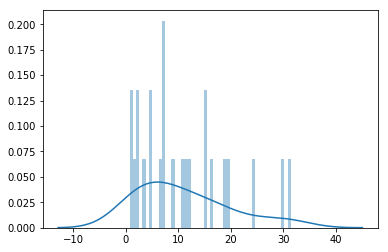

In [551]:
idx = 507
sns.distplot(temp.iloc[idx][temp.iloc[idx] > 0].values.tolist(), bins=50)

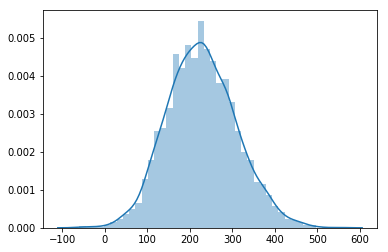

In [448]:
# sns.distplot(temp.sum(axis=1))
# sns.distplot(temp.iloc[normal_idx].sum(axis=1))
# sns.distplot(temp[train.target == 0].sum(axis=1))
sns.distplot(temp.iloc[bbiggu_idx].sum(axis=1))

In [352]:
train = data[~data.target.isna()]
test = data[data.target.isna()]

In [353]:
target = train['target']

In [309]:
[col for col in train.columns if "unique" in col]

['var_0_is_unique',
 'var_1_is_unique',
 'var_2_is_unique',
 'var_3_is_unique',
 'var_4_is_unique',
 'var_5_is_unique',
 'var_6_is_unique',
 'var_7_is_unique',
 'var_8_is_unique',
 'var_9_is_unique',
 'var_10_is_unique',
 'var_11_is_unique',
 'var_12_is_unique',
 'var_13_is_unique',
 'var_14_is_unique',
 'var_15_is_unique',
 'var_16_is_unique',
 'var_17_is_unique',
 'var_18_is_unique',
 'var_19_is_unique',
 'var_20_is_unique',
 'var_21_is_unique',
 'var_22_is_unique',
 'var_23_is_unique',
 'var_24_is_unique',
 'var_25_is_unique',
 'var_26_is_unique',
 'var_27_is_unique',
 'var_28_is_unique',
 'var_29_is_unique',
 'var_30_is_unique',
 'var_31_is_unique',
 'var_32_is_unique',
 'var_33_is_unique',
 'var_34_is_unique',
 'var_35_is_unique',
 'var_36_is_unique',
 'var_37_is_unique',
 'var_38_is_unique',
 'var_39_is_unique',
 'var_40_is_unique',
 'var_41_is_unique',
 'var_42_is_unique',
 'var_43_is_unique',
 'var_44_is_unique',
 'var_45_is_unique',
 'var_46_is_unique',
 'var_47_is_unique',
 '

In [354]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target'] + [col for col in train.columns if "order" in col]]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=400, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[400]	training's auc: 0.894568	valid_1's auc: 0.877124
[800]	training's auc: 0.904823	valid_1's auc: 0.885501
[1200]	training's auc: 0.909889	valid_1's auc: 0.889876
[1600]	training's auc: 0.913511	valid_1's auc: 0.892654
[2000]	training's auc: 0.916544	valid_1's auc: 0.894598
[2400]	training's auc: 0.919131	valid_1's auc: 0.89573
[2800]	training's auc: 0.921753	valid_1's auc: 0.89699
[3200]	training's auc: 0.924145	valid_1's auc: 0.897959
[3600]	training's auc: 0.926425	valid_1's auc: 0.898682
[4000]	training's auc: 0.928614	valid_1's auc: 0.899335
[4400]	training's auc: 0.930601	valid_1's auc: 0.899904
[4800]	training's auc: 0.932446	valid_1's auc: 0.900304
[5200]	training's auc: 0.934307	valid_1's auc: 0.900756
[5600]	training's auc: 0.935997	valid_1's auc: 0.901062
[6000]	training's auc: 0.937731	valid_1's auc: 0.901335
[6400]	training's auc: 0.939363	valid_1's auc: 0.901557
Early stopping, best iteration is:
[

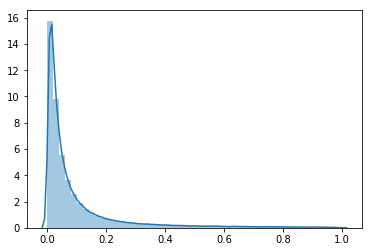

In [562]:
sns.distplot(oof_lgb)

In [554]:
bbiggu['pred2'] = oof_lgb

In [555]:
t = bbiggu[bbiggu.bbiggu == 1].sort_values(['pred'])

In [557]:
good_idx = t[t.pred2 > 0.1].index

In [366]:
bbiggu[bbiggu.bbiggu == 1].pred2.max()

0.14105559862409256

In [375]:
temp = bbiggu[(bbiggu.pred < 0.1) & (bbiggu.pred2 > 0.1)].sort_values('pred2').ID_code.values

In [379]:
tt = bbiggu[bbiggu.ID_code.isin(temp)]
ttt = bbiggu[~bbiggu.ID_code.isin(temp)]

In [411]:
tt.pred2 = 0.09

In [412]:
bbi = tt.append(ttt)

In [413]:
roc_auc_score(bbi.target, bbi.pred2)

0.902229825514217

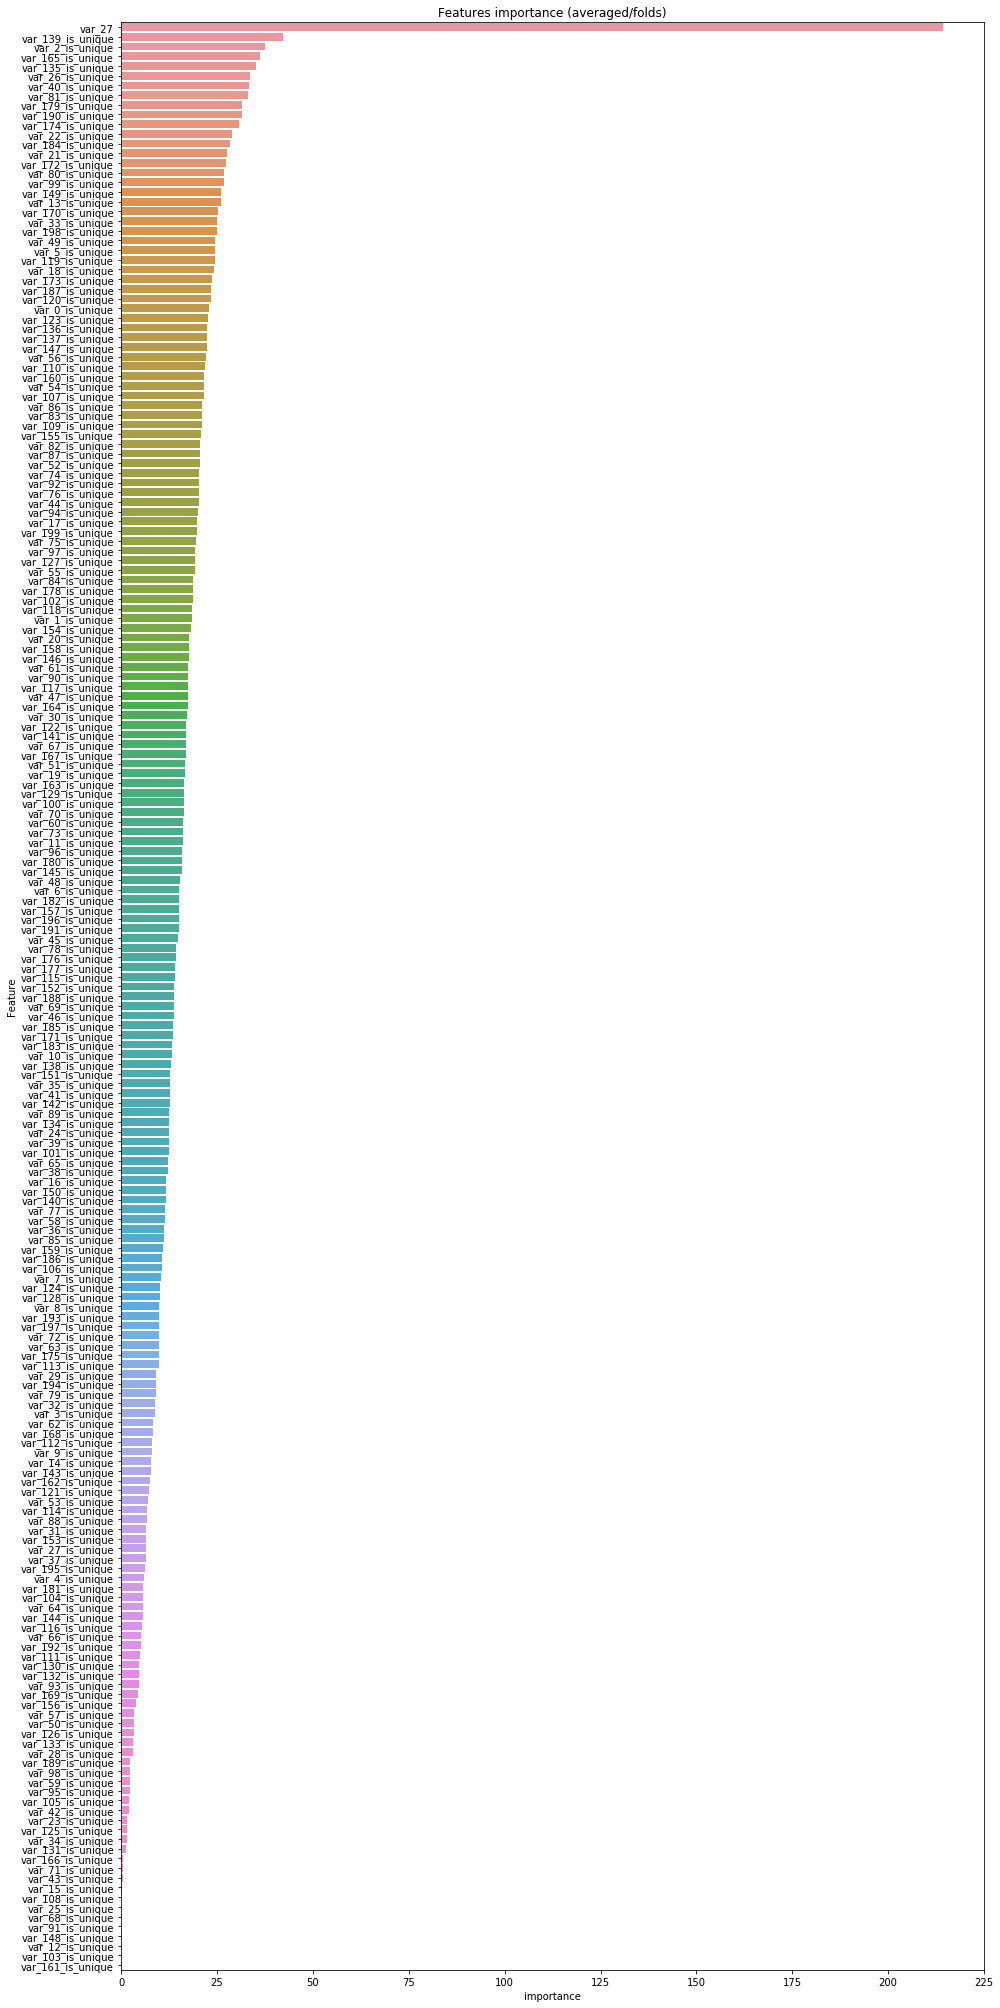

In [338]:
best_features = (feature_importance[["Feature", "importance"]]
                    .groupby("Feature")
                    .mean()
                    .sort_values(by="importance", ascending=False)[199:])

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.reset_index())
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [566]:
test.target = predictions_lgb

In [567]:
sub = pd.read_csv('./data/sample_submission.csv')

In [568]:
unchange = sub[~sub.ID_code.isin(test.ID_code)]

In [569]:
sub = test[['ID_code', 'target']].append(unchange).sort_index()

In [584]:
sub.to_csv('./data/sub_feature_unique.csv', index=False)

In [580]:
sub_temp = pd.read_csv('./data/sub_feature_order_unique.csv')

In [581]:
t = sub[sub.ID_code.isin(test.ID_code)]

In [582]:
t['new_'] = sub_temp[sub_temp.ID_code.isin(test.ID_code)].target

In [583]:
t.corr()

target      new_
target  1.000000  0.997987
new_    0.997987  1.000000

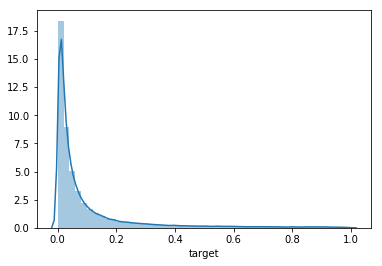

In [260]:
sns.distplot(sub[sub.target != 0].target)

In [288]:
t = pd.read_csv('./data/sub_feature_order_unique.csv')

In [267]:
test.sort_index().head()

ID_code    target    var_0   var_1  var_10  var_100  var_101  var_102  \
3    test_3  0.193693   8.5374 -1.3222  0.0095   1.7021   2.5363   3.8763   
7    test_7  0.152987  17.3035 -2.4212  4.0355 -22.7363  11.6984  18.0784   
11  test_11  0.028126  10.6137 -2.1898  2.4620 -14.9298  23.1641   5.2171   
15  test_15  0.032004  14.8595 -4.5378  3.9229 -13.1135  19.4192  21.7291   
16  test_16  0.396442  14.1732 -5.1490 -5.8456  -2.4555  12.4817  17.8563   

    var_103  var_104  var_105  var_106  var_107  var_108  var_109   var_11  \
3    1.5173  13.4083   2.8965   7.0919  21.6304  14.2000  23.0368  -5.0659   
7    1.7108   9.2897   5.5384  13.0755  23.3108  14.1560  14.5899   1.6185   
11   1.7760   8.4856   5.1361   9.2391  20.9397  14.3065  14.7051 -13.6379   
15   1.3708   8.5129   3.4646  10.2735  18.3579  14.0931  18.8384   4.5794   
16   1.6619  12.7459   3.3414   8.7188  32.1891  14.1171  24.1989  -1.4712   

    var_110  var_111  var_112  var_113  var_114  var_115  var_116  var_117  \
3   10.3445   6.0369   5.0227  12.6600   2.1278   4.0592   1.9084  11.6095   
7    5.5510   7.7358   5.2163  13.7452   1.5873   6.0762   4.9045  20.5785   
11   6.5382   7.3042   0.3595   9.2448   3.0790  -1.5080   3.2687  27.8681   
15  11.9147   5.0342   2.4073   4.0204   1.7479   5.6146   3.4006  19.4596   
16   3.5466   5.9148   3.6096  14.2046   1.0620   0.9760   5.2912  23.6110   

    var_118  var_119   var_12  var_120  var_121  var_122  var_123  var_124  \
3    7.5397   8.1972  14.0526  20.0844  10.4440   8.4676   5.0350   4.3103   
7  -14.9020   7.3964  14.1455  32.9594   8.5667   0.9854  11.8573   3.4626   
11  -0.0404   0.6835  14.0421  17.9783  12.8389  -9.8682   7.1661   2.4212   
15 -19.1851   2.1211  13.9799   2.6359  13.7112  -4.9358  -0.6807   2.2599   
16  -0.2232   6.2817  13.8920  35.2890  11.2028   2.7077  -4.8505   6.8041   

    var_125  var_126  var_127  var_128  var_129   var_13  var_130  var_131  \
3   12.0067  13.7149   1.6143  -1.2328  22.7248  13.5010  12.6609   0.8039   
7   12.0244  14.1143  -0.8310  -0.7450  15.3384   9.2276  11.3860   1.0311   
11  12.3438  14.1982  -3.7962  -2.0037   9.1008  10.9537  12.8915   0.8837   
15  12.3701  12.5878   1.1086  -0.9755  11.7853   3.9441  11.7813   0.2343   
16  12.4458  12.9556   2.4920  -1.7391  13.9817   3.4970  12.5864  -0.3851   

    var_132  var_133  var_134  var_135  var_136  var_137  var_138  var_139  \
3    4.7666   6.7888   5.8537  -4.5434  19.0111  12.6907  -2.9322  12.7898   
7    8.3112   7.4290  -3.6762 -11.7978  11.7961   1.1644  -3.2493   5.7673   
11   9.1595   6.8706  -0.9022   1.1312   9.6963   5.2609  -5.6162  20.0114   
15   8.8701   6.7799 -10.3026  12.6143  12.8396   4.8148   5.6719  14.4241   
16   7.3224   6.5241 -13.6993  -1.0805  25.2014  30.3768  -1.7047  15.3888   

     var_14  var_140  var_141  var_142  var_143  var_144  var_145  var_146  \
3    8.7660  12.0466  13.1646   7.7063  11.6549   9.8274   1.8061   8.6963   
7   10.3202   9.8482   6.9077  15.8785  11.6216   7.9618   2.5143  14.5101   
11   5.2869  -0.8365 -10.4020   7.8237   6.9431   9.2886   6.9954   8.0427   
15   6.6847   0.2916   5.9912  16.6044  17.6997  10.6712   4.3438   9.5814   
16   5.1491   1.9366  15.6920  13.8495  12.0874   8.7523   6.4264  13.4222   

    var_147  var_148  var_149   var_15  var_150  var_151  var_152  var_153  \
3    1.8057   3.8265 -16.3027  14.7352  13.7106   9.7908   5.8497  15.4378   
7   -0.0356   4.0720  -0.7705  15.1863  17.7689  11.6995   4.3652  12.9432   
11   5.1568   4.2629 -27.7671  14.7810  15.7695  17.5612   6.5782  15.7226   
15  -6.7417   4.1531  -3.8782  13.9142  17.9134   6.5012   5.2230  14.6550   
16  -5.5824   4.5175  -8.0646  14.1057  14.2164  10.2420   5.0280  17.3642   

    var_154  var_155  var_156  var_157  var_158  var_159   var_16  var_160  \
3    5.0372  -8.7673  13.6035  -3.5002  13.9785  14.6118  10.0383  19.7251   
7    8.2277  -2.9284  13.3862  -8.4828  28.2227   8.6334  10.4344  33.2387   
11   9.8001   0.2822  14

In [265]:
test.head()

ID_code    target    var_0   var_1   var_10  var_100  var_101  var_102  \
7    test_7  0.152987  17.3035 -2.4212   4.0355 -22.7363  11.6984  18.0784   
17  test_17  0.024817   9.0936 -8.7414   1.4059   3.6922  11.7575  36.2402   
18  test_18  0.176143  15.7875  0.1671 -11.7156 -20.7810  17.4896  27.4262   
21  test_21  0.067754  14.3356  0.2317   2.2075 -19.6787  17.1966  29.6026   
24  test_24  0.010634  14.1844 -9.1044  -4.0461  -3.1851  13.4667  27.4468   

    var_103  var_104  var_105  var_106  var_107  var_108  var_109   var_11  \
7    1.7108   9.2897   5.5384  13.0755  23.3108  14.1560  14.5899   1.6185   
17   1.4822  11.7041   2.5428   5.8293  15.6129  14.4198  20.7810  -4.8320   
18   1.6980  14.8031   3.1149   7.0228  20.3282  14.4266  19.1991 -10.7639   
21   1.6342   7.8006   4.9521   8.4537  17.8985  14.2810  24.1252  -2.1847   
24   1.6719   9.6487   4.1958   9.1398   8.4784  14.0479  18.0191  -9.4851   

    var_110  var_111  var_112  var_113  var_114  var_115  var_116  var_117  \
7    5.5510   7.7358   5.2163  13.7452   1.5873   6.0762   4.9045  20.5785   
17  -1.5919   5.7935   2.6232  10.9542   4.5107   0.3491  -0.0474  14.5762   
18   5.3033   7.8399   1.3332  16.2959   3.8614   3.0790   3.6750  37.3462   
21   9.4407   5.9536   4.0935   9.8290   5.0393   6.3780   4.6417   2.8839   
24   7.8124   5.2948   0.6638   5.5766   4.1739   2.0795   1.2926  21.5158   

    var_118  var_119   var_12  var_120  var_121  var_122  var_123  var_124  \
7  -14.9020   7.3964  14.1455  32.9594   8.5667   0.9854  11.8573   3.4626   
17 -18.5012   7.6528  13.9907  20.0021  13.6686   7.0526  11.7965   4.7428   
18   2.4197  -0.5003  13.8599  31.3310  12.7374   8.3291  -9.0132   4.5314   
21 -14.0407   0.0966  14.0581  48.0231  11.2958  -1.2930   0.3915   1.1997   
24  -8.9025   3.6016  14.0924   9.6407   9.9183   1.9266   9.1305   4.9560   

    var_125  var_126  var_127  var_128  var_129   var_13  var_130  var_131  \
7   12.0244  14.1143  -0.8310  -0.7450  15.3384   9.2276  11.3860   1.0311   
17  12.5541  11.8754   1.2593  -1.4762   7.6389   4.6164  12.4635   0.5003   
18  12.8825  12.3294   5.7900   2.3739  17.5709  12.0673  11.0031   1.1307   
21  12.8616  14.4305  -2.3763  -4.6429  17.3405  -0.0779  13.0740   0.9484   
24  12.4204  12.4848  -1.6230  -2.9914  23.6770   0.2121  12.6732   0.6757   

    var_132  var_133  var_134  var_135  var_136  var_137  var_138  var_139  \
7    8.3112   7.4290  -3.6762 -11.7978  11.7961   1.1644  -3.2493   5.7673   
17   5.7811   7.2478   0.1546 -15.9605  27.1251  10.2447  -1.4669   7.8757   
18   9.6295   6.6325 -10.3339   4.8971  37.9160  30.5514   2.8800   3.9400   
21   6.4072   6.9358  -3.3890  -1.8652  38.4405  16.0275  -3.5079  16.1713   
24   6.9182   6.9171  -2.8116  -9.0535  13.9996   0.9271  -2.1151   3.2191   

     var_14  var_140  var_141  var_142  var_143  var_144  var_145  var_146  \
7   10.3202   9.8482   6.9077  15.8785  11.6216   7.9618   2.5143  14.5101   
17   4.8209   0.4057   4.1395   3.2191  13.9053   8.5517   0.5458   9.6749   
18   4.3904  -0.4846   5.7032  13.6161  13.5469   6.7368   9.3147   4.0634   
21   4.2255   3.3078  -4.9012   9.3021  14.4764   8.9627   0.5284   9.0169   
24   6.8614  10.1972  -8.2990  15.0634   9.8570   9.2583   3.0415   8.1207   

    var_147  var_148  var_149   var_15  var_150  var_151  var_152  var_153  \
7   -0.0356   4.0720  -0.7705  15.1863  17.7689  11.6995   4.3652  12.9432   
17   0.2513   3.8043  21.3333  14.3365  15.6960   6.0531   8.0350  16.4918   
18  -6.6125   3.9087  -0.5970  14.6607  14.8013   8.9762   5.6788  16.3560   
21  -9.9641   4.1494  11.6945  14.4843  17.8750  10.9886  10.7741  14.2729   
24   1.5294   3.8660  11.4910  14.8581  15.9711   9.3944  14.7809  20.6481   

    var_154  var_155  var_156  var_157  var_158  var_159   var_16  var_160  \
7    8.2277  -2.9284  13.3862  -8.4828  28.2227   8.6334  10.4344  33.2387   
17   1.4902  -1.1847  12.2287 -10.6207  18.7187   9.7017   8.2884  40.2461   
18   4.7820   9.67

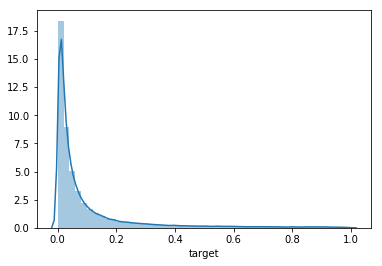

In [259]:
sns.distplot(t[t.ID_code.isin(test.ID_code)].target)

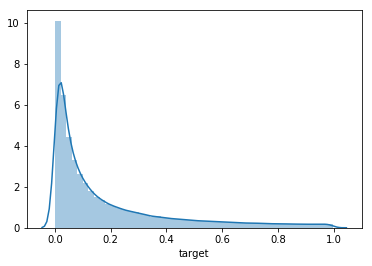

In [255]:
sns.distplot(pd.read_csv('./data/sub_simple_lgb.csv').target)

In [220]:
sub.target.value_counts()

0    200000
Name: target, dtype: int64

In [208]:
predictions_lgb.shape.ta

(100000,)

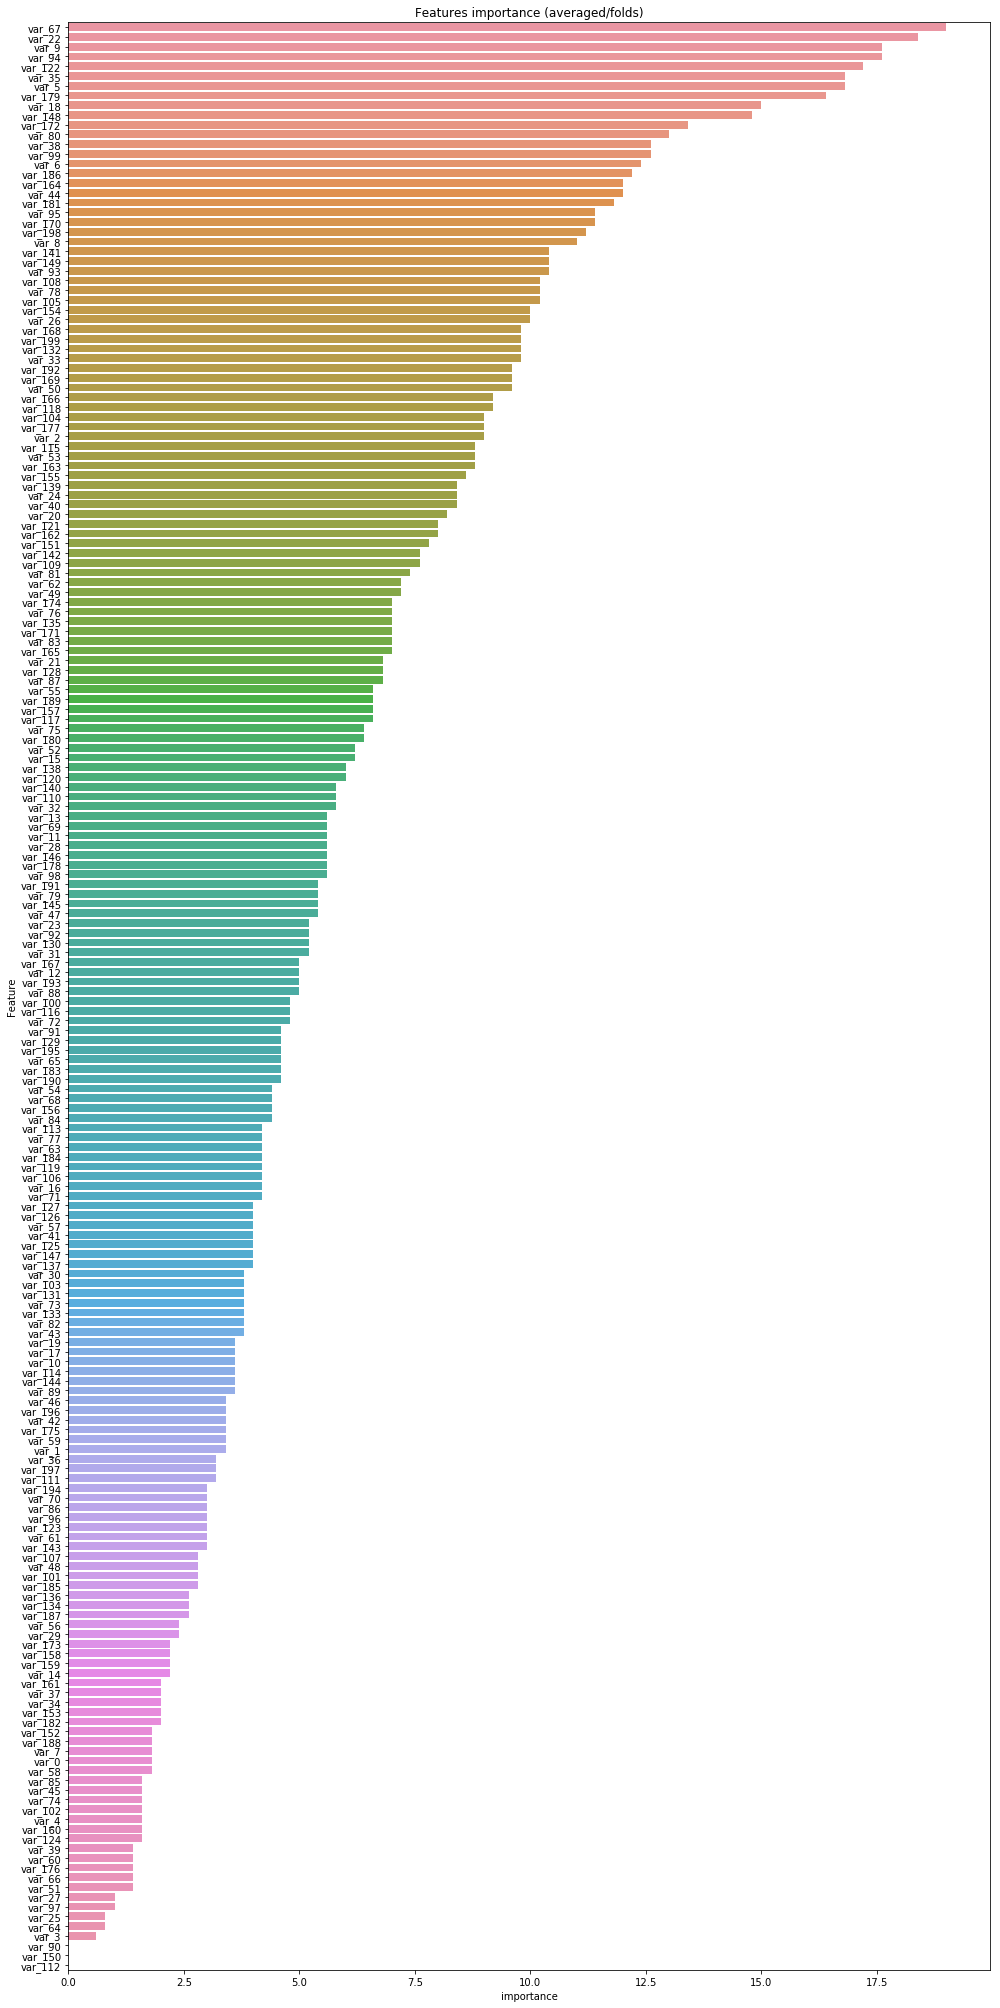

In [392]:
best_features = (feature_importance[["Feature", "importance"]]
                    .groupby("Feature")
                    .mean()
                    .sort_values(by="importance", ascending=False))

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.reset_index())
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

# Unique Value

In [196]:
unique_dic = {}

for col in tqdm(col_list):
    
    unique_dic[col] = {}
    
    target_0 = set(np.around(train_0[col].unique(), 4))
    target_1 = set(np.around(train_1[col].unique(), 4))
    target_0_and_1 = target_0.intersection(target_1)
    target_0 = target_0.difference(target_0_and_1)
    target_1 = target_1.difference(target_0_and_1)
    
    unique_dic[col]['target_0'] = sorted(target_0)
    unique_dic[col]['target_1'] = sorted(target_1)
    unique_dic[col]['target_0_and_1'] = sorted(target_0_and_1)

In [198]:
def func(data):
    return data.values.tolist()

In [220]:
unique_hash = {}
for col in tqdm(col_list):
    train[col] = np.around(train[col], 4)
    unique_hash[col] = train[[col, 'target']].groupby(col)['target'].agg(func).to_frame()

In [240]:
for col in tqdm(col_list):
    unique_hash[col].target = [np.around(np.mean(v),4) for v in unique_hash[col].target.values]

In [260]:
train_unique = train[['ID_code']]

for col in tqdm(col_list):
    train_unique[col] = train[col].map(unique_hash[col].to_dict()['target'])

# Unique Dist Plot

In [223]:
train.shape

(200000, 202)

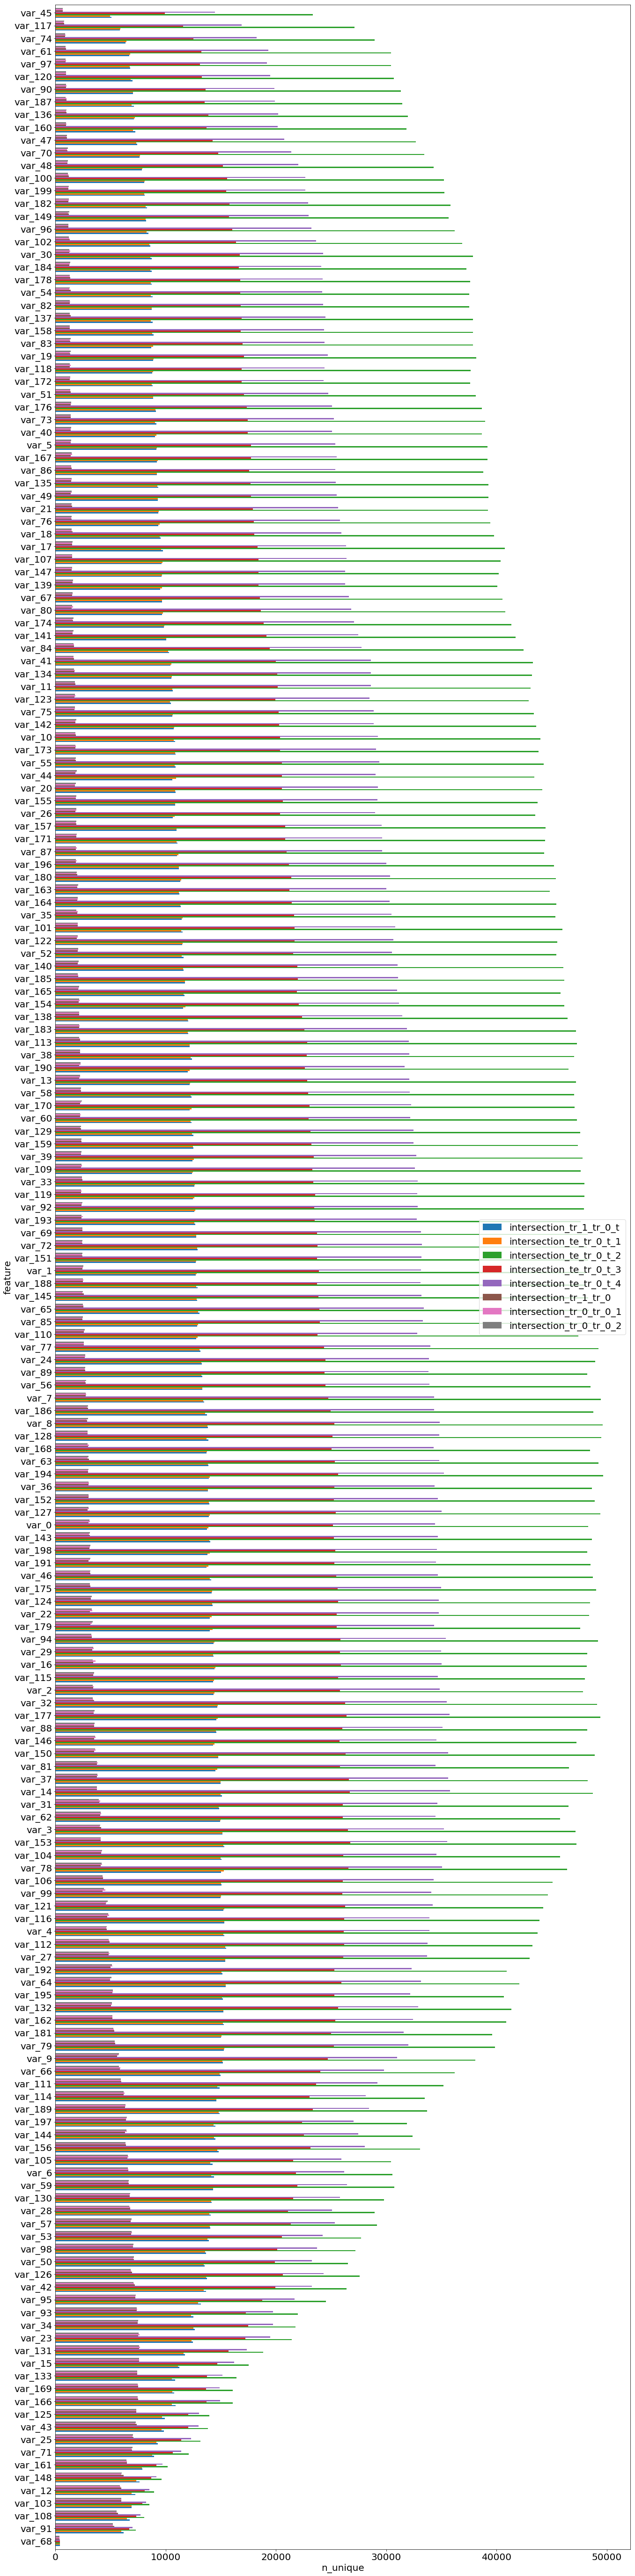

In [131]:
unique_df = unique_df.sort_values('data_nunique').reset_index(drop=True).copy()
unique_df[['intersection_tr_1_tr_0_t', 'intersection_te_tr_0_t_1','intersection_te_tr_0_t_2', 'intersection_te_tr_0_t_3', 'intersection_te_tr_0_t_4', 'intersection_tr_1_tr_0','intersection_tr_0_tr_0_1', 'intersection_tr_0_tr_0_2']].plot(kind='barh' ,figsize=(22, 100), fontsize=20, width=0.8)
plt.yticks(unique_df.index, unique_df['feature'].values)
plt.xlabel('n_unique', fontsize=20)
plt.ylabel('feature', fontsize=20)
plt.legend(loc='center right', fontsize=20)

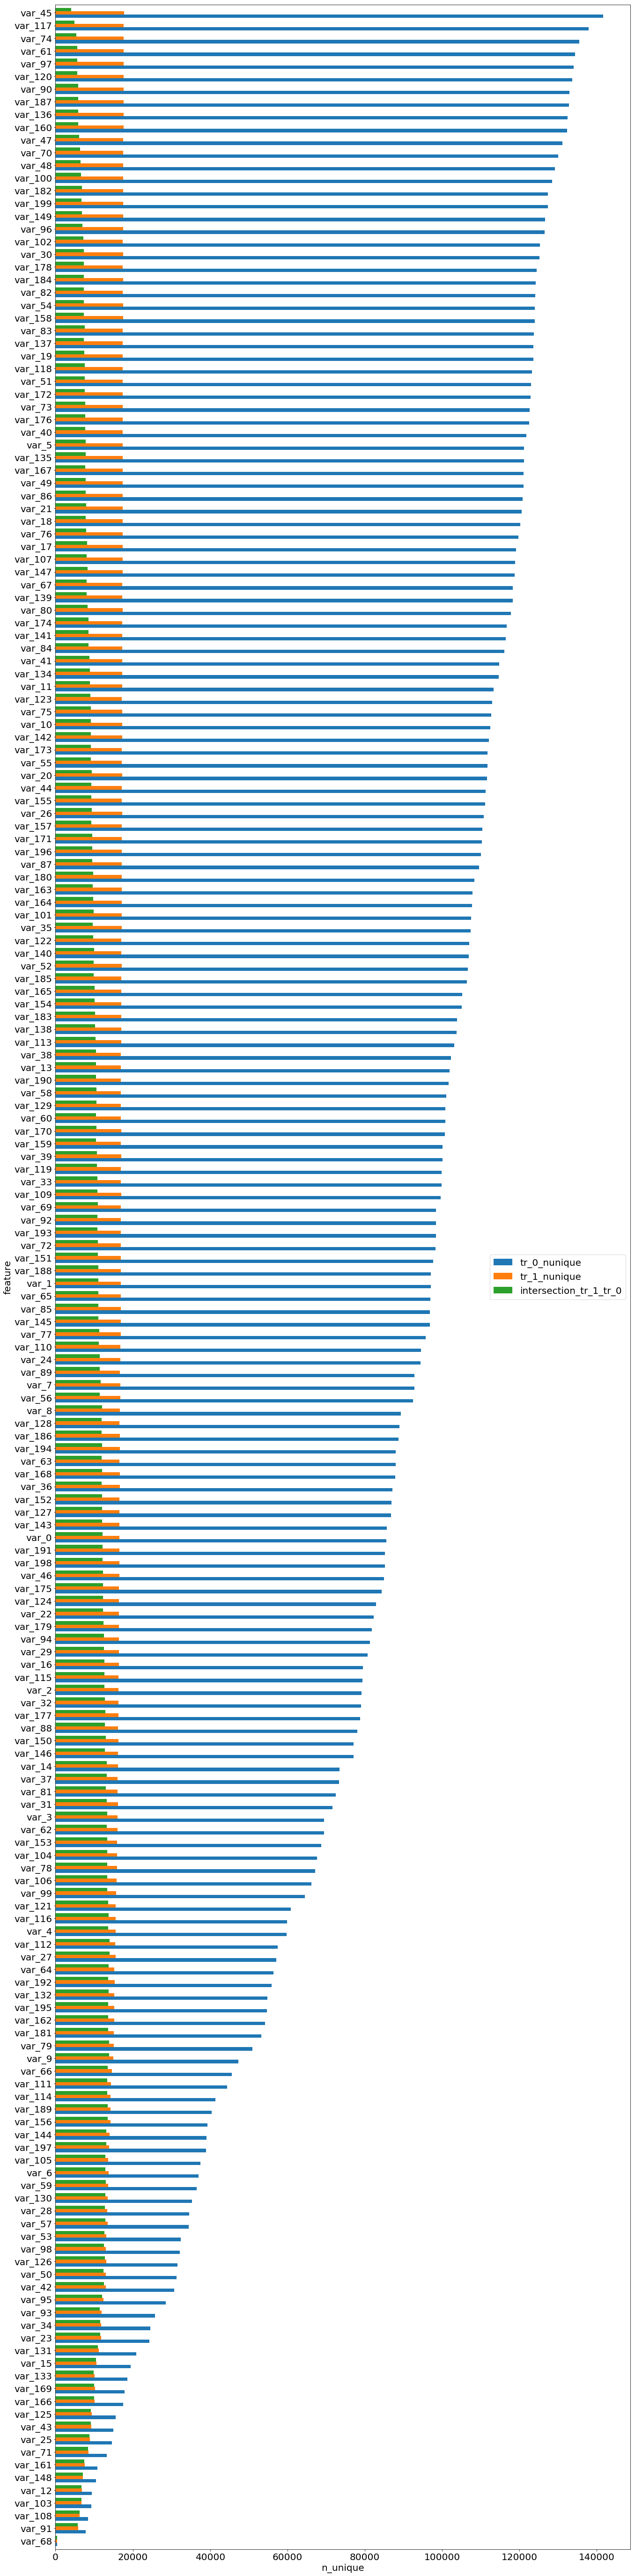

In [187]:
unique_df = unique_df.sort_values('tr_0_nunique').reset_index(drop=True).copy()
unique_df[['tr_0_nunique', 'tr_1_nunique', 'intersection_tr_1_tr_0']].plot(kind='barh' ,figsize=(22, 100), fontsize=20, width=0.8)
plt.yticks(unique_df.index, unique_df['feature'].values)
plt.xlabel('n_unique', fontsize=20)
plt.ylabel('feature', fontsize=20)
plt.legend(loc='center right', fontsize=20)

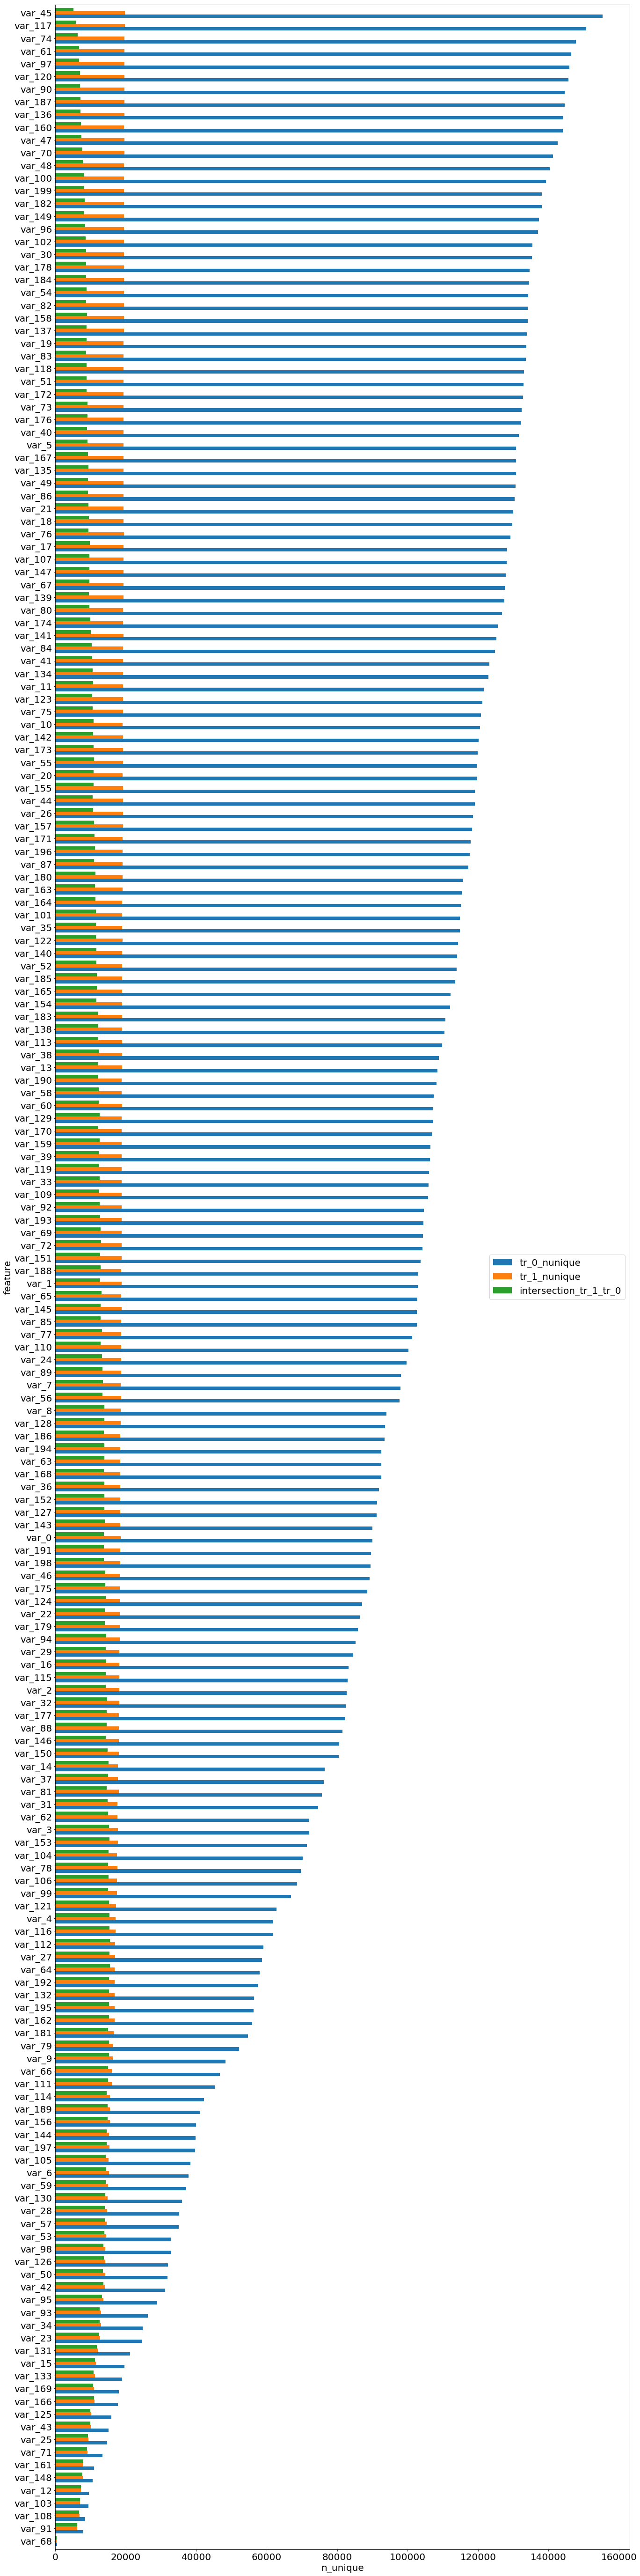

In [182]:
unique_df = unique_df.sort_values('tr_0_nunique').reset_index(drop=True).copy()
unique_df[['tr_0_nunique', 'tr_1_nunique', 'intersection_tr_1_tr_0']].plot(kind='barh' ,figsize=(22, 100), fontsize=20, width=0.8)
plt.yticks(unique_df.index, unique_df['feature'].values)
plt.xlabel('n_unique', fontsize=20)
plt.ylabel('feature', fontsize=20)
plt.legend(loc='center right', fontsize=20)